In [1]:
import numpy as np
#import gromacs
import pandas as pd
import os, fnmatch
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import MDAnalysis as mda
import pickle
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Jump to 
- [plotting tail unsaturation series](#tail_unsat)
- [plotting cholesterol series](#cholser)
- [plotting of 45% cholesterol -vs- saturation index series](#45chol)

# Simulation class definition
This class includes all methods and attributes to obtain results from ethanol-membrane intreraction simulations with Martini within **permeability** project with Jacopo Fralicciardi and Bert Poolman.

This is prepared in a way that the readout shall be easily concatenated in a Pandas Dataframe for further analysis including multi-indexing etc...

### Function definitions
a few handy functions with a quite general meaning 

In [2]:
# import the definitions from the separate script
from permeana_class_simulation import *

# Search through the simulations
on my local disk on md39.

In the following section, I will loop through the simulation folders and 
obtain results from my analysis scripts.

This will be put together in a Pandas Dataframe with multiindexing at the end. 

The multiindex will use properties as parsed from the directory names.

In [3]:
tpr_files = find("topol.tpr", os.curdir)

In [4]:
records = []
sims    = []
for f in tpr_files:
    sim = Simulation(os.path.dirname(f))
    sims.append(sim)
    if (not "prep" in sim.dirname) and ("titration" in sim.dirname) :
        try:
            records.append(sim.as_record)
        except:
            print("Troubles loading simulation in dir {} \n Skipping it.".format(sim.dirname))

Problems loading the box-x XVG file in dir ./cholesterol26p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLR/sat-unsat_107-72_d_20/sim1_awh_LOrdered
Troubles loading simulation in dir ./cholesterol26p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLR/sat-unsat_107-72_d_20/sim1_awh_LOrdered 
 Skipping it.
Problems loading the box-x XVG file in dir ./cholesterol26p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLR/sat-unsat_71-108_d_30/sim1_awh_LOrdered
Troubles loading simulation in dir ./cholesterol26p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLR/sat-unsat_71-108_d_30/sim1_awh_LOrdered 
 Skipping it.
Problems loading the box-x XVG file in dir ./cholesterol26p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLR/sat-unsat_161-18_d_5/sim1_awh_LOrdered
Troubles loading simulation in dir ./cholesterol26p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLR/sat-unsat

# Table of simulations

In [5]:
# create large DataFrame data set from records
data = pd.DataFrame.from_records(records, columns=Simulation.column_labels)

data.head()

,satur index,sterol conc,particle,starting conf,compress,perm,perm err,thickness
0,0.00,26,S,LOrdered,NaN,11.281835,1.620699,NaN
1,0.15,45,R,LOrdered,158.913652,10.175333,3.041855,4.314890
2,0.25,45,R,LOrdered,135.988588,19.794465,6.626883,4.244257
3,0.40,45,R,LOrdered,105.085819,23.187986,5.543970,4.145742
4,0.30,45,R,LOrdered,121.394172,21.270065,6.768933,4.213634


In [6]:
# create multiindex from columns 1-8
midata = data.set_index(list(Simulation.column_labels[:4]))

# This is how to slice it (an example)
idx = pd.IndexSlice
#          parts of the multi-index ...   , membrane property(ies)
midata.loc[idx[:, 0, "S"], :].sort_index(level="satur index").head(6)

compress       perm  \
satur index sterol conc particle starting conf                          
0.00        0           S        fluid            3.926684   7.678913   
                                 gel            328.980988   0.061099   
0.05        0           S        fluid           57.750930  29.284861   
                                 gel            335.894288   0.046054   
0.10        0           S        fluid           56.134320  32.531796   
                                 gel            328.427557   0.087512   

                                                perm err  thickness  
satur index sterol conc particle starting conf                       
0.00        0           S        fluid          2.303661   4.995208  
                                 gel            0.020503   4.996088  
0.05        0           S        fluid          5.297639   4.276122  
                                 gel            0.040756   4.998883  
0.10        0           S        fluid          6.344147   4.205392  
                                 gel            0.044862   4.979652

## Test plot and slicing
Here I perform a simple test of plotting and slicing and manipulating of the dataset

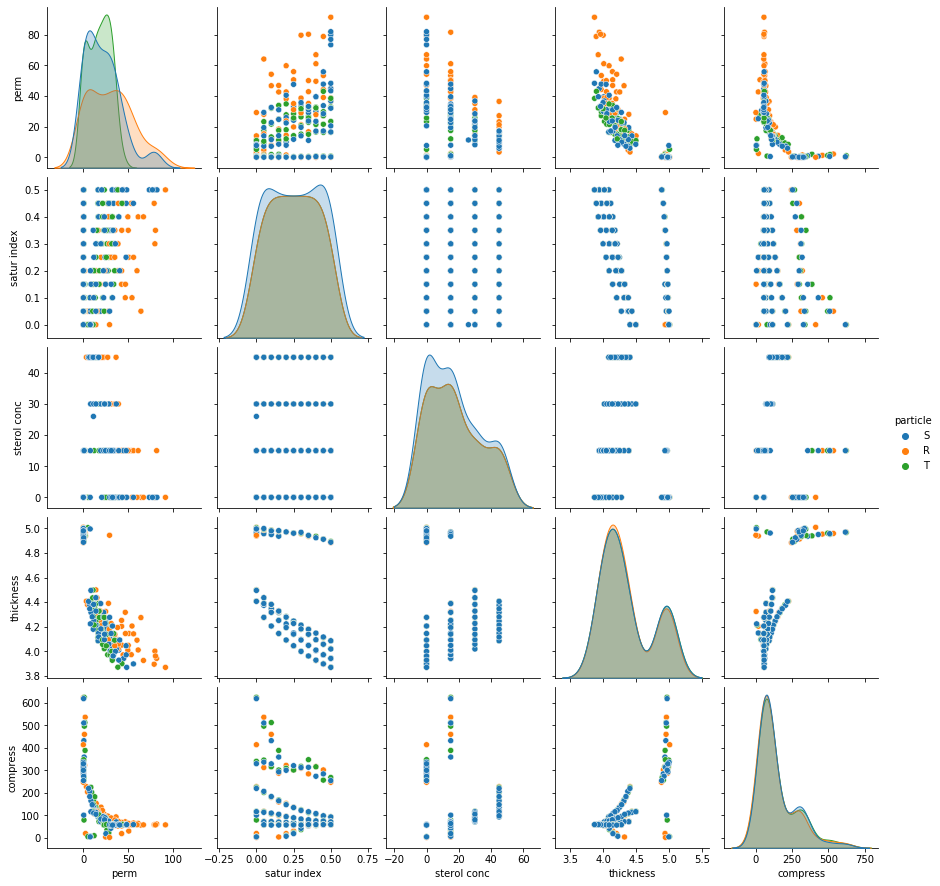

In [7]:
sns.pairplot(data.loc[:, ['particle', 'perm', 'satur index', 'sterol conc', 'thickness', 'compress']], hue="particle")

## Save it!

In [8]:
# Save the dataframe with the analyzed trajectories
# CSV is not much larger than other data formats and can be read-in by most software suites including e.g. Excel
data.to_csv(path_or_buf="dataFrame_all_sims.csv")

# Save the list of simulation objects using pickle
with open("objects_all_sims.pickle", "wb") as f: pickle.Pickler(f).dump(sims)

In [4]:
# optionally, load sims (list of Simulation instances) - depickle
with open("objects_all_sims.pickle", "rb") as f: sims = pickle.load(f)

# Dataframe analysis separately
plotting and working with the Pandas Dataframe dataset will be done in a separate Jupyter notebook, 
so that this one is clean and finishes with just the creation of the dataset.

# AWH profiles plotting
As working with the pickled objects also requires defining the Simulation class,
I will make the AWH-profile plots here in this notebook. 

## Cholesterol series – PO– & DP– plots
<a name="cholser"></a>
In this plot, I want to show the profiles of 
simulations with 0,15,30,45% cholesterol
. + DOPC as a reference profile

Here, I find and select the corresponding simulations:

In [5]:
po_sims = []
dp_sims = []

# using only Small particle as permeant
particle = "EOLS"
    
for s in sims:
    if particle in s.dirname and not "(1)" in s.dirname and not "AWHk" in s.dirname and not "26" in s.dirname:
        print(s.dirname)
        try:
            s.parse_dirname()
            print(s.d, s.sterol_conc, s.particle)
        except:
            pass
        try:
            if s.d == 0.5:
                po_sims.append(s)
                print(" ➡ added this one to the 💧 PO-list\n")
            if s.d == 0.0:
                dp_sims.append(s)
                print(" ➡ added this one to the 🧊 DP-list\n")
        except:
            pass

    if "DOPC" in s.dirname:
        print("➡️ Found DOPC simulation in dir {}".format(s.dirname))
        dopc_sim = s
        

./cholesterol45p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_82-36_d_15/sim1_awh_LOrdered
0.15 45 S
./cholesterol45p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_58-60_d_25/sim1_awh_LOrdered
0.25 45 S
./cholesterol45p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_22-96_d_40/sim1_awh_LOrdered
0.4 45 S
./cholesterol45p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_46-72_d_30/sim1_awh_LOrdered
0.3 45 S
./cholesterol45p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_106-12_d_5/sim1_awh_LOrdered
0.05 45 S
./cholesterol45p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_118-0_d_0/sim1_awh_LOrdered
0.0 45 S
 ➡ added this one to the 🧊 DP-list

./cholesterol45p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_94-24_d_10/sim1_awh_LOrdered
0.1 45 S
./choleste

Now, sort the lists after sterol concentrations:

In [6]:
for sim_list, sign in zip([po_sims, dp_sims], [1, -1]):
    sim_list.sort(key=lambda s: sign*s.sterol_conc)

### Free energy profiles

in the code below,
I plot the symmetrized AWH-free energy profiles.
The differences from symmetrization 
give rise to the error estimates included in the plot. 

The plot can be futher improved 
by using a simulation snapshot as a background. 

In [7]:
# let's use some cool palette!
sns.set_palette("PRGn", n_colors=8) #len(po_sims))

# use a larger font
mpl.rcParams.update({'font.size': 13})

troubles with simulation in ./cholesterol00p_PC_variousTails_sims/membrane_thickness_unsaturated_tails/DOPC_di-C16-C18-1/awh-perm
troubles with simulation in ./cholesterol00p_PC_variousTails_sims/membrane_thickness_unsaturated_tails/DOPC_di-C16-C18-1/awh-perm


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inces" which is no longer supported as of 3.3 and will become an error two minor releases later


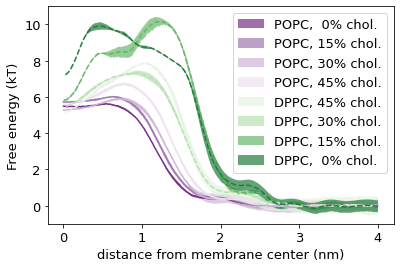

In [8]:
for sim_list, xxpc in zip([po_sims, dp_sims], ["POPC", "DPPC"]):
    # DOPC - reference - at the background
    s = dopc_sim
    try:
        (x_half, awhsym, awhsym_err) = prep_to_plot(s.awh_x, s.awh)
        plt.plot(x_half, awhsym, color='black')
        plt.fill_between(x=x_half, 
                         y1=awhsym+awhsym_err,
                         y2=awhsym-awhsym_err,
                         label="DOPC, {}% {}sterol".format(s.sterol_conc, s.sterol_type),
                         color='black', alpha=0.7)
    except:
        print("troubles with simulation in {}".format(s.dirname))

    if "POPC" in xxpc:
        linestyle = "-"
    else:
        linestyle = "--"
        
    
    for s in sim_list:
        if (xxpc == 'POPC' and s.starting_conf != 'gel') or (xxpc == 'DPPC' and s.starting_conf != 'fluid'):
            try:
                    (x_half, awhsym, awhsym_err) = prep_to_plot(s.awh_x, s.awh)
                    plt.plot(x_half, awhsym, ls=linestyle)
                    plt.fill_between(x=x_half, 
                                     y1=awhsym+awhsym_err,
                                     y2=awhsym-awhsym_err,
                                     label="{},{: 3d}% {}.".format(xxpc, s.sterol_conc, s.sterol_type[:-1]),
                                     alpha=0.7)
            except:
                print("troubles plotting simulation in {}".format(s.dirname))

plt.legend()
fig = plt.gca()
fig.figure.set_size_inches([6.2,4.0])
plt.ylim([-1, 11])
plt.ylabel("Free energy (kT)")
plt.xlabel("distance from membrane center (nm)")
plt.savefig("awh_dG_profiles_all_sterol-concs-{}.png".format(xxpc, particle), dpi=150, bbox_inces='tight')
plt.show()

### Friction profiles

in the code below,
I plot the symmetrized friction profiles.
The differences from symmetrization 
give rise to the error estimates included in the plot. 

These plots would benefit from further processing,
namely smoothening of the noise. 

However, at the current status it makes the necessary points. 

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inces" which is no longer supported as of 3.3 and will become an error two minor releases later


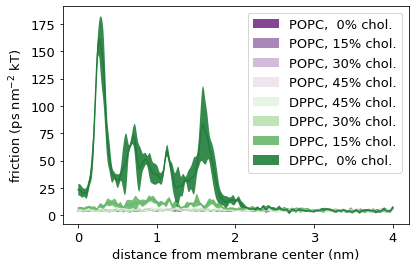

In [9]:
for sim_list, xxpc in zip([po_sims, dp_sims], ["POPC", "DPPC"]):
    for s in sim_list:
        try:
            if (xxpc == 'POPC' and s.starting_conf != 'gel') or (xxpc == 'DPPC' and s.starting_conf != 'fluid'):
                # dividing by 1k to change the unit from ps to ns
                (x_half, fricsym, fricsym_err) = prep_to_plot(s.awh_x, s.fric/1000.0, shift_to_zero=False, filt_freq=0.150)
                x_half = -s.awh_x[:len(fricsym)]
                plt.plot(x_half, fricsym)
                plt.fill_between(x=x_half, 
                                 y1=fricsym+fricsym_err,
                                 y2=fricsym-fricsym_err,
                                 label="{},{: 3d}% {}.".format(xxpc, s.sterol_conc, s.sterol_type[:-1]),
                                 alpha=0.9)
        except:
            pass
fig = plt.gca()
fig.figure.set_size_inches([6.2,4.0])
plt.legend()
plt.ylabel("friction (ps nm$^{-2}$ kT)")
plt.xlabel("distance from membrane center (nm)")
plt.savefig("friction_profiles_all_sterol-concs-{}.png".format(xxpc, particle), dpi=150, bbox_inces='tight')
plt.show()

In [10]:
# let's use some cool palette!
sns.set_palette("twilight", n_colors=4) #len(po_sims))

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inces" which is no longer supported as of 3.3 and will become an error two minor releases later


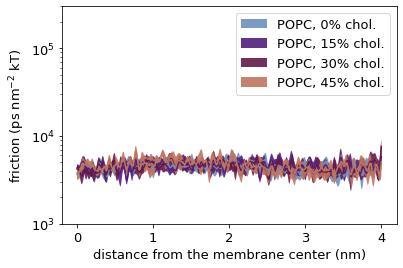

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inces" which is no longer supported as of 3.3 and will become an error two minor releases later


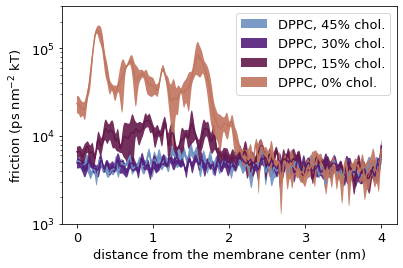

In [11]:
for sim_list, xxpc in zip([po_sims, dp_sims], ["POPC", "DPPC"]):
    for s in sim_list:
        try:
            if (xxpc == 'POPC' and s.starting_conf != 'gel') or (xxpc == 'DPPC' and s.starting_conf != 'fluid'):
                (x_half, fricsym, fricsym_err) = prep_to_plot(s.awh_x, s.fric, 
                                                              shift_to_zero=False, 
                                                              filt_freq=0.150)
                x_half = -s.awh_x[:len(fricsym)]
                plt.plot(x_half, fricsym)
                plt.fill_between(x=x_half, 
                                 y1=fricsym+fricsym_err,
                                 y2=fricsym-fricsym_err,
                                 label="{}, {}% {}.".format(xxpc, s.sterol_conc, s.sterol_type[:-1]),
                                 alpha=0.9)
        except:
            pass
    plt.legend()
    plt.yscale("log")
    plt.ylim([1e3, 3e5])
    plt.ylabel("friction (ps nm$^{-2}$ kT)")
    plt.xlabel("distance from the membrane center (nm)")
    plt.savefig("friction_profiles_{}_sterol-concs-{}-log.png".format(xxpc, particle), dpi=150, bbox_inces='tight')
    plt.show()

## tail unaturation series - plots
<a name="tail_unsat"></a>

In this section, I will plot the data from PC membranes with various unsaturation indices. 

First, let's select which compositions we will plot.

PO: skip d=0 (gel) and plot only every 0.1, 0.2 ... 0.5
DP: plot only sims d<=0.2

In [12]:
# re-using variables for the following lists (DIRTY!)
del(po_sims, dp_sims)
po_sims = []  # the "fluid" part of the series and meta-stable in fluid phase
dp_sims = []  # the "gel" prt of the series at the gel phase 

# choose small particle
particle = "EOLS"

# satur-ind "d" selection for po sims
po_d_sel = np.linspace(0.1, 0.5, num=5)
print("Choosing onld d in {} for fluid series".format(po_d_sel))

# going through the sims and selecting...
for s in sims:
    if particle in s.dirname and not "(1)" in s.dirname and not "AWHk" in s.dirname and s.sterol_conc == 0:
        #print(s.dirname)
        try:
            s.parse_dirname()
            print(s.d, s.starting_conf)
        except:
            pass
        try:
            # using isclose to compare floating-point numbers (0.3 was skipped without it!)
            if "fluid" in s.starting_conf and np.isclose(s.d, po_d_sel).any(): 
                po_sims.append(s)
                print(" ➡ added to 💧 PO-list\n")
            elif "gel" in s.starting_conf and s.d <= 0.2:
                dp_sims.append(s)
                print(" ➡ added to 🧊 DP-list\n")
        except:
            print("Something went wrong?")

    # this shall already be done from previous steps, here a repeat
    if "DOPC" in s.dirname:
        print("➡️ Found DOPC simulation in dir {}".format(s.dirname))
        dopc_sim = s
        
# sort the simulation lists after their satur indices "d"        
for l in [po_sims, dp_sims]:
    l.sort(key=lambda s: s.d)

Choosing onld d in [0.1 0.2 0.3 0.4 0.5] for fluid series
0.0 gel
 ➡ added to 🧊 DP-list

0.0 fluid
0.45 gel
0.45 fluid
0.3 gel
0.3 fluid
 ➡ added to 💧 PO-list

0.05 gel
 ➡ added to 🧊 DP-list

0.05 fluid
0.25 gel
0.25 fluid
0.15 gel
 ➡ added to 🧊 DP-list

0.15 fluid
0.35 gel
0.35 fluid
0.4 gel
0.4 fluid
 ➡ added to 💧 PO-list

0.2 gel
 ➡ added to 🧊 DP-list

0.2 fluid
 ➡ added to 💧 PO-list

0.5 gel
0.5 fluid
 ➡ added to 💧 PO-list

0.1 gel
 ➡ added to 🧊 DP-list

0.1 fluid
 ➡ added to 💧 PO-list

➡️ Found DOPC simulation in dir ./cholesterol00p_PC_variousTails_sims/membrane_thickness_unsaturated_tails/DOPC_di-C16-C18-1/awh-perm


In [13]:
# just printing out for a check
for s in dp_sims+po_sims:
    print(s.starting_conf, s.d, s.dg)

gel 0.0 10.147318112499999
gel 0.05 13.746033015000002
gel 0.1 9.329906874999999
gel 0.15 11.705734225
gel 0.2 10.743044900000001
fluid 0.1 6.079411072499999
fluid 0.2 5.886237875
fluid 0.3 5.9133388257499995
fluid 0.4 5.8054343
fluid 0.5 5.6309096025


### Free energy profiles (unsat series)
above I selected the simulations to plot, 
here I plot the Free energy profiles.

In [14]:
# let's use some cool palette!
sns.set_palette("plasma", n_colors=len(po_sims))

# use a larger font
mpl.rcParams.update({'font.size': 16})

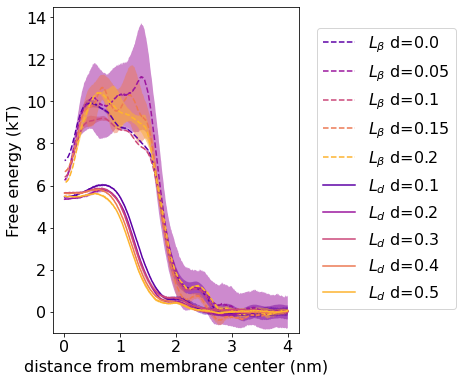

In [15]:
for sim_list, memphase in zip([dp_sims, po_sims], [u"$L_β$", u"$L_d$"]):
    if "d" in memphase:
        linestyle = "-"
    else:
        linestyle = "--"
        
    for s in sim_list:
        if True:
            try:
                    (x_half, awhsym, awhsym_err) = prep_to_plot(s.awh_x, s.awh)
                    plt.plot(x_half, awhsym, 
                             ls=linestyle,
                             label=u"{} d={}".format(memphase, s.d))
                    plt.fill_between(x=x_half, 
                                     y1=awhsym+awhsym_err,
                                     y2=awhsym-awhsym_err,
                                     label=None,
                                     alpha=0.5)
            except:
                print("troubles plotting simulation in {}".format(s.dirname))

plt.legend(bbox_to_anchor=[1.04, 0.96])
fig = plt.gca()
fig.figure.set_size_inches([4.4,6.0])
plt.ylim([-1, 14.5])
plt.ylabel("Free energy (kT)")
plt.xlabel("distance from membrane center (nm)")
plt.savefig("awh_dG_profiles_all_unsat-ndx-{}.png".format(particle), dpi=150, bbox_inches='tight')
plt.show()

In [120]:
# let's use some cool palette!
sns.set_palette("plasma_r", n_colors=2)

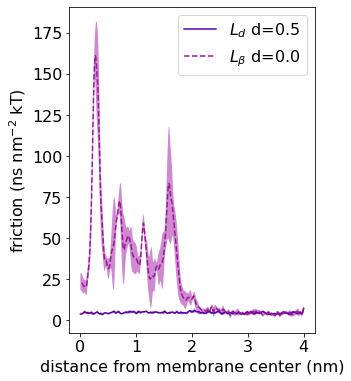

In [148]:
for sim_list, memphase in zip([po_sims, dp_sims], [u"$L_d$", u"$L_β$"]):
    if "d" in memphase:
        linestyle = "-"
    else:
        linestyle = "--"
        
    for s in sim_list:
        if ("d" in memphase and s.d>=0.45) or ("d" not in memphase and s.d<0.04):
            try:
                    # multiplying by 1000 to change the unit to ns / nm2 (kT)
                    (x_half, fricsym, fricsym_err) = prep_to_plot(s.awh_x, s.fric/1000.0, shift_to_zero=False, filt_freq=0.15)
                    plt.plot(x_half, fricsym, 
                             ls=linestyle,
                             label=u"{} d={}".format(memphase, s.d))
                    plt.fill_between(x=x_half, 
                                     y1=fricsym+fricsym_err,
                                     y2=fricsym-fricsym_err,
                                     label=None,
                                     alpha=0.5)
            except:
                print("troubles plotting simulation in {}".format(s.dirname))

plt.legend()
#plt.ylim([-1, 14.5])
fig = plt.gca()
fig.figure.set_size_inches([4.4,6.0])
plt.ylabel("friction (ns nm$^{-2}$ kT)")
plt.xlabel("distance from membrane center (nm)")
plt.savefig("friction_profiles_selected_unsat-ndx-{}.png".format(particle), dpi=150, bbox_inches='tight')
plt.show()

## Free energy profiles - 45% sterols but varying saturation index
<a name="45chol"> </a>

In [149]:
sims_chol45 = []
for s in sims:
    try:
        if (s.sterol_conc == 45 and s.particle == "S" and not "(1)" in s.dirname):
            sims_chol45.append(s)
            print(s.dirname)
    except:
        pass
        

./cholesterol45p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_82-36_d_15/sim1_awh_LOrdered
./cholesterol45p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_58-60_d_25/sim1_awh_LOrdered
./cholesterol45p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_22-96_d_40/sim1_awh_LOrdered
./cholesterol45p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_46-72_d_30/sim1_awh_LOrdered
./cholesterol45p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_106-12_d_5/sim1_awh_LOrdered
./cholesterol45p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_118-0_d_0/sim1_awh_LOrdered
./cholesterol45p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_94-24_d_10/sim1_awh_LOrdered
./cholesterol45p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_70-48_d_20/sim

In [150]:
sims_chol45.sort(key=lambda s: s.d)

In [151]:
# let's use some cool palette!
sns.set_palette("coolwarm_r", n_colors=len(sims_chol45))

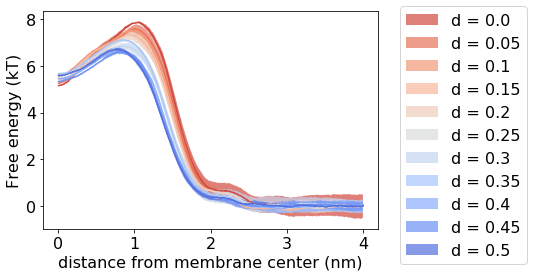

In [152]:
for sim_list, xxpc in zip([sims_chol45,], ["all", ]):
    for s in sim_list:
        linestyle = "-"
        if (s.sterol_conc == 45 and s.particle == "S"):
            try:
                    (x_half, awhsym, awhsym_err) = prep_to_plot(s.awh_x, s.awh)
                    plt.plot(x_half, awhsym, ls=linestyle)
                    plt.fill_between(x=x_half, 
                                     y1=awhsym+awhsym_err,
                                     y2=awhsym-awhsym_err,
                                     label="d = {}".format(s.d),
                                     alpha=0.7)
            except:
                print("troubles plotting simulation in {}".format(s.dirname))

plt.legend(bbox_to_anchor=[1.04, 1.06])
plt.ylabel("Free energy (kT)")
plt.xlabel("distance from membrane center (nm)")
plt.savefig("awh_dG_profiles_various-d_sterol-conc45-{}.png".format(xxpc, particle), dpi=150, bbox_inches='tight')
plt.show()

## Free energy profiles - 30% sterols but varying saturation index
<a name="30chol"> </a>

In [153]:
sims_chol30 = []
for s in sims:
    try:
        if (s.sterol_conc == 30 and s.particle == "S" and not "(1)" in s.dirname):
            sims_chol30.append(s)
            print(s.dirname)
    except:
        pass
        

./cholesterol30p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_107-72_d_20/sim1_awh_LOrdered
./cholesterol30p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_71-108_d_30/sim1_awh_LOrdered
./cholesterol30p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_161-18_d_5/sim1_awh_LOrdered
./cholesterol30p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_0-179_d_50/sim1_awh_LOrdered
./cholesterol30p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_179-0_d_0/sim1_awh_LOrdered
./cholesterol30p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_143-36_d_10/sim1_awh_LOrdered
./cholesterol30p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_17-162_d_45/sim1_awh_LOrdered
./cholesterol30p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_89-90_d_25

In [154]:
sims_chol30.sort(key=lambda s: s.d)

In [155]:
# let's use some cool palette!
sns.set_palette("coolwarm_r", n_colors=len(sims_chol30))

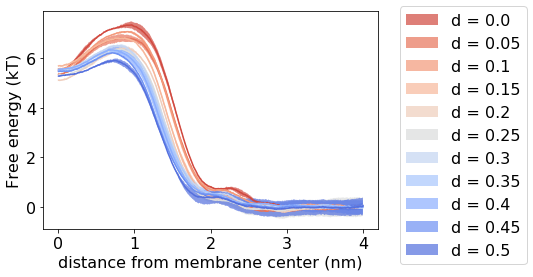

In [156]:
for sim_list, xxpc in zip([sims_chol30,], ["all", ]):
    for s in sim_list:
        linestyle = "-"
        if (s.sterol_conc == 30 and s.particle == "S"):
            try:
                    (x_half, awhsym, awhsym_err) = prep_to_plot(s.awh_x, s.awh)
                    plt.plot(x_half, awhsym, ls=linestyle)
                    plt.fill_between(x=x_half, 
                                     y1=awhsym+awhsym_err,
                                     y2=awhsym-awhsym_err,
                                     label="d = {}".format(s.d),
                                     alpha=0.7)
            except:
                print("troubles plotting simulation in {}".format(s.dirname))

plt.legend(bbox_to_anchor=[1.04, 1.06])
plt.ylabel("Free energy (kT)")
plt.xlabel("distance from membrane center (nm)")
plt.savefig("awh_dG_profiles_various-d_sterol-conc30-{}.png".format(xxpc, particle), dpi=150, bbox_inches='tight')
plt.show()

## Free energy profiles - 15% sterols but varying saturation index
<a name="15chol"> </a>

In [24]:
sims_chol15 = []
for s in sims:
    try:
        if (s.sterol_conc == 15 and s.particle == "S" and not "(1)" in s.dirname and "gel" in s.dirname):
            sims_chol15.append(s)
            print(s.dirname)
    except:
        pass
        

./cholesterol15p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_107-72_d_20/sim1_awh_gel
./cholesterol15p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_71-108_d_30/sim1_awh_gel
./cholesterol15p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_161-18_d_5/sim1_awh_gel
./cholesterol15p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_0-179_d_50/sim1_awh_gel
./cholesterol15p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_179-0_d_0/sim1_awh_gel
./cholesterol15p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_143-36_d_10/sim1_awh_gel
./cholesterol15p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_17-162_d_45/sim1_awh_gel
./cholesterol15p_PC_variousTails_sims/saturation_DPPC-POPC_titration/perm_particle_EOLS/sat-unsat_89-90_d_25/sim1_awh_gel
./cholesterol15p_PC_v

In [25]:
sims_chol15.sort(key=lambda s: s.d)

In [26]:
# let's use some cool palette!
sns.set_palette("coolwarm_r", n_colors=len(sims_chol15))

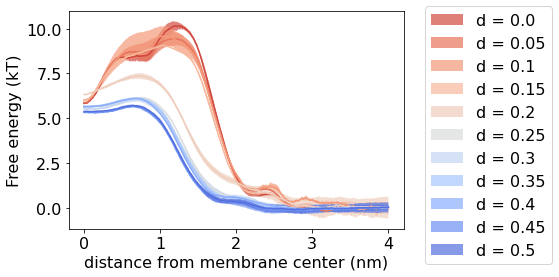

In [27]:
for sim_list, xxpc in zip([sims_chol15,], ["all", ]):
    for s in sim_list:
        linestyle = "-"
        if (s.sterol_conc == 15 and s.particle == "S"):
            try:
                    (x_half, awhsym, awhsym_err) = prep_to_plot(s.awh_x, s.awh)
                    plt.plot(x_half, awhsym, ls=linestyle)
                    plt.fill_between(x=x_half, 
                                     y1=awhsym+awhsym_err,
                                     y2=awhsym-awhsym_err,
                                     label="d = {}".format(s.d),
                                     alpha=0.7)
            except:
                print("troubles plotting simulation in {}".format(s.dirname))

plt.legend(bbox_to_anchor=[1.04, 1.06])
plt.ylabel("Free energy (kT)")
plt.xlabel("distance from membrane center (nm)")
plt.savefig("awh_dG_profiles_various-d_sterol-conc15-initcond-gel-{}.png".format(xxpc, particle), dpi=150, bbox_inches='tight')
plt.show()

## Free energy profiles – 00% sterols


In [28]:
# let's use some cool palette!
sns.set_palette("coolwarm_r", n_colors=2*len(po_sims))

# use a larger font
mpl.rcParams.update({'font.size': 16})

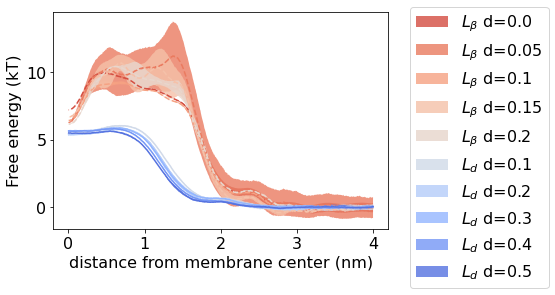

In [23]:
for sim_list, memphase in zip([dp_sims, po_sims], [u"$L_β$", u"$L_d$"]):
    if "d" in memphase:
        linestyle = "-"
    else:
        linestyle = "--"
        
    for s in sim_list:
        if (s.sterol_conc == 0 and s.particle == "S"):
            try:
                    (x_half, awhsym, awhsym_err) = prep_to_plot(s.awh_x, s.awh)
                    plt.plot(x_half, awhsym, ls=linestyle)
                    plt.fill_between(x=x_half, 
                                     y1=awhsym+awhsym_err,
                                     y2=awhsym-awhsym_err,
                                     label=u"{} d={}".format(memphase, s.d),
                                     alpha=0.8)
            except:
                print("troubles plotting simulation in {}".format(s.dirname))


plt.legend(bbox_to_anchor=[1.04, 1.06])
plt.ylabel("Free energy (kT)")
plt.xlabel("distance from membrane center (nm)")
plt.savefig("awh_dG_profiles_various-d_sterol-conc00-initcond-gel-{}.png".format(xxpc, particle), dpi=150, bbox_inches='tight')
plt.show()